In [211]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r3.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

In [281]:
df = df_raw.copy()

df = df[df['model']=='Resnet18']

df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']==0.1]
df = df[(df['mapping_method']=='naive')]
# df = df[df['GDC'] == 'on']
df = df[df['read_noise_scale'] == 0]
df = df[df['drift_noise_scale'] == 1]
df = df[df['model_type'] == 'vanilla']  

### ADC DAC split

In [1]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r2.5_io.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

df = df_raw.copy()

df = df[df['model']=='Resnet18']
df = df[df['read_noise_scale'] == 0]
df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']==0.1]
df = df[(df['inp_noise']==0)]
df = df[(df['GDC']=='on')]

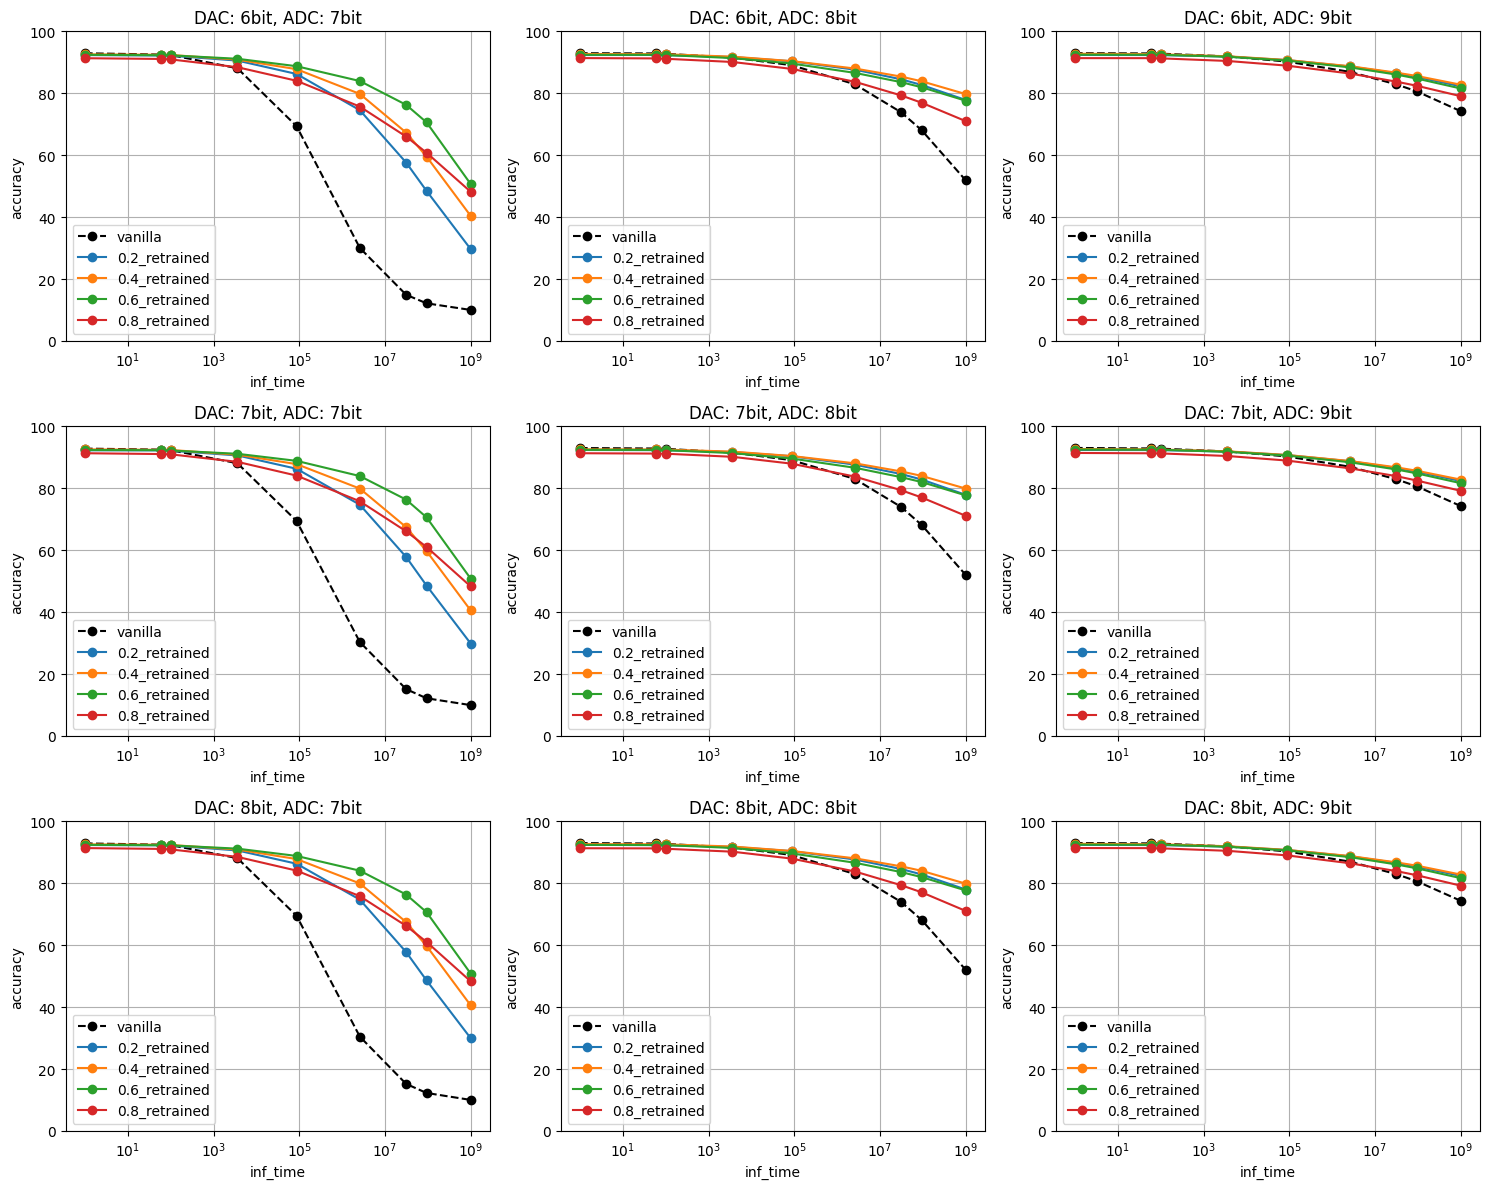

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 예시용: rawdata = pd.read_csv("your_data.csv")

# 필요한 열이 존재하는지 확인

required_columns = {'inf_time', 'accuracy', 'model_type', 'dac_res', 'adc_res'}
assert required_columns.issubset(df.columns), "필수 column이 rawdata에 없습니다."

# 유일한 dac_res, adc_res 값 파악
dac_vals = sorted(df['dac_res'].unique())
adc_vals = sorted(df['adc_res'].unique())

# subplot 생성
fig, axes = plt.subplots(len(dac_vals), len(adc_vals), figsize=(5 * len(adc_vals), 4 * len(dac_vals)), squeeze=False)

# 각 subplot에 대해 plot
for i, dac in enumerate(dac_vals):
    for j, adc in enumerate(adc_vals):
        ax = axes[i][j]
        subset = df[(df['dac_res'] == dac) & (df['adc_res'] == adc)]
        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model]
            
            if model=='vanilla':
                ax.plot(model_data['inf_time'], model_data['accuracy'], label=model, marker='o', color='black', linestyle='--')
            else:
                ax.plot(model_data['inf_time'], model_data['accuracy'], label=model, marker='o')

        ax.set_title(f'DAC: {dac}, ADC: {adc}')
        ax.set_xlabel('inf_time')
        ax.set_ylabel('accuracy')
        ax.set_xscale('log')
        ax.set_ylim(0, 100)
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


## Mapping split

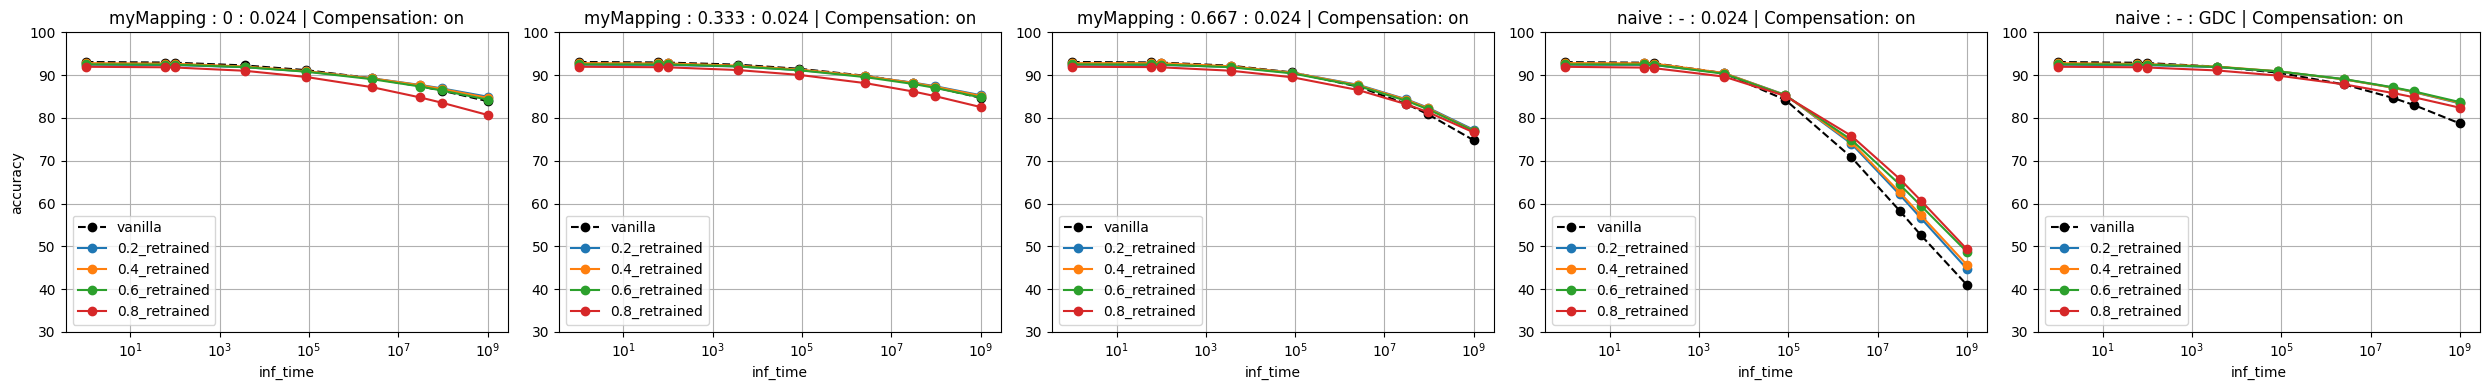

In [245]:
import matplotlib.pyplot as plt
import pandas as pd

# mapping_method 와 distortion_f 를 조합해서 새로운 column 생성
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str)+' : ' + df['alpha'].astype(str)

# 유일한 값
gdc_vals = sorted(df['GDC'].unique())
mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# subplot 구조 (row: GDC, column: mapping_distortion)
fig, axes = plt.subplots(len(gdc_vals), len(mapping_distortion_vals),
                         figsize=(5 * len(mapping_distortion_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, mapping_distortion in enumerate(mapping_distortion_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['mapping_distortion'] == mapping_distortion)]

        if subset.empty:
            ax.set_title(f'{mapping_distortion} | Compensation: {gdc}\n(No Data)')
            ax.axis('off')  # subplot 유지하지만 표시 안 함
            continue

        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model].sort_values('inf_time')
            if model == 'vanilla':
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, color='black', linestyle='--', marker='o')
            else:
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, marker='o', linestyle='-')

        ax.set_title(f'{mapping_distortion} | Compensation: {gdc}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        if gdc == "on":
            ax.set_ylim(30, 100)
        else:
            ax.set_ylim(0, 100)

        ax.legend()
        ax.grid(True)
        ax.set_xscale('log')

plt.tight_layout()
plt.show()

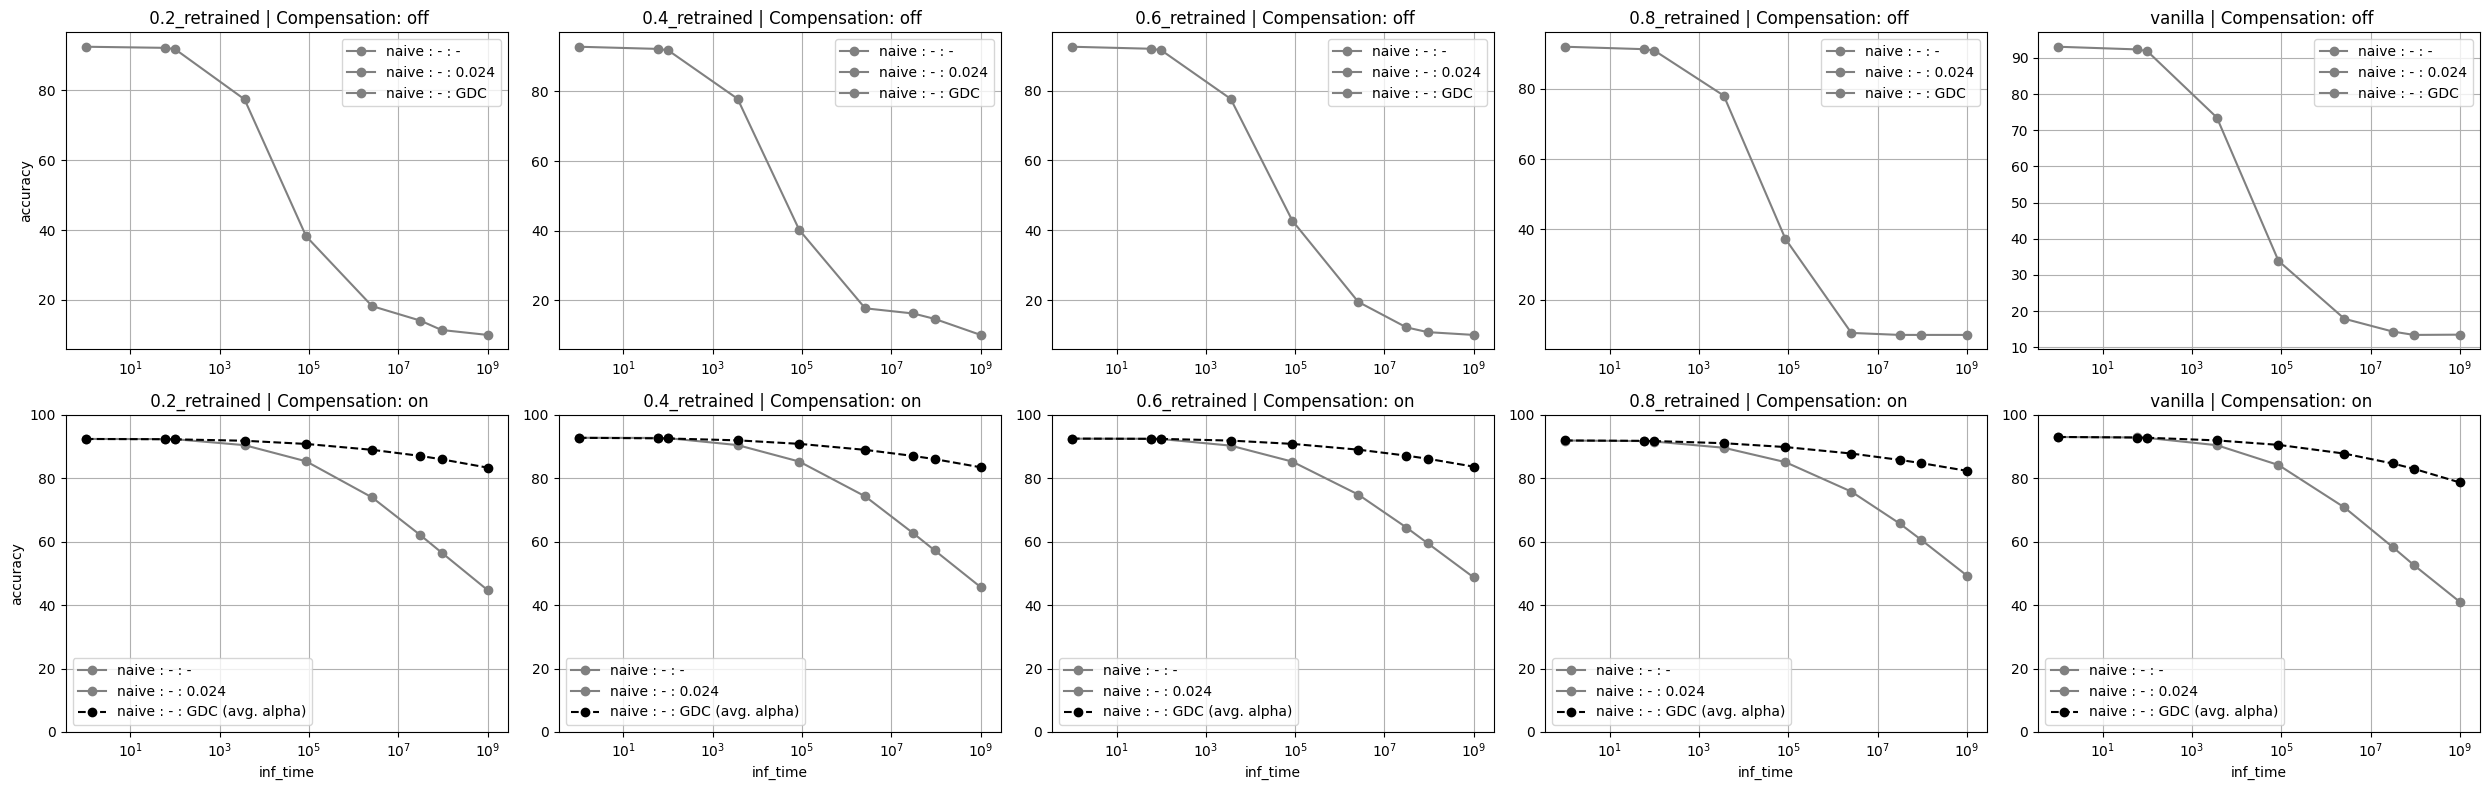

In [ ]:

# 유일한 값 추출
gdc_vals = sorted(df['GDC'].unique())
model_vals = sorted(df['model_type'].unique())

df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str)+' : ' + df['alpha'].astype(str)

mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# subplot 개수 정의 (row: GDC, col: model_type)
fig, axes = plt.subplots(len(gdc_vals), len(model_vals),
                         figsize=(5 * len(model_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, model in enumerate(model_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['model_type'] == model)]

        for mapping_distortion in mapping_distortion_vals:
            md_data = subset[subset['mapping_distortion'] == mapping_distortion].sort_values('inf_time')

            # naive 중에서도 alpha == 'GDC' 조건 분리
            is_naive = 'naive' in mapping_distortion
            is_alpha_gdc = not md_data.empty and 'alpha' in md_data.columns and (md_data['alpha'] == 'GDC').any()

            if is_naive and is_alpha_gdc:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion + ' (avg. alpha)',
                        color='black', linestyle='--', marker='o')
            elif is_naive:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion,
                        color='grey', linestyle='-', marker='o')
            else:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion, marker='o')
        
            # if 'naive' in mapping_distortion:
            #     ax.plot(md_data['inf_time'], md_data['accuracy'],
            #                 label=mapping_distortion, color='black', linestyle='--', marker='o')
            # else:
            #     ax.plot(md_data['inf_time'], md_data['accuracy'],
            #             label=mapping_distortion, marker='o')
            

        ax.set_title(f' {model} | Compensation: {gdc}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        # GDC가 "on"일 때 ylim 설정
        if gdc == "on":
            ax.set_ylim(70, 100)


        ax.grid(True)
        ax.legend()
        ax.set_xscale('log')

plt.tight_layout()

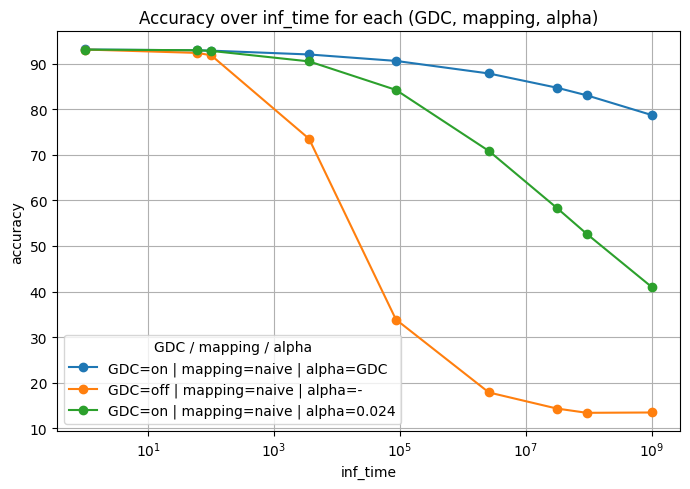

In [282]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

# 유일한 조합으로 반복
unique_combinations = df[['GDC', 'mapping_method', 'alpha']].drop_duplicates()

for _, row in unique_combinations.iterrows():
    subset = df[
        (df['GDC'] == row['GDC']) &
        (df['mapping_method'] == row['mapping_method']) &
        (df['alpha'] == row['alpha'])
    ].sort_values('inf_time')

    label = f"GDC={row['GDC']} | mapping={row['mapping_method']} | alpha={row['alpha']}"
    ax.plot(subset['inf_time'], subset['accuracy'], marker='o', label=label)

ax.set_xscale('log')
ax.set_xlabel('inf_time')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy over inf_time for each (GDC, mapping, alpha)')

ax.legend(title='GDC / mapping / alpha')
ax.grid(True)
plt.tight_layout()
plt.show()


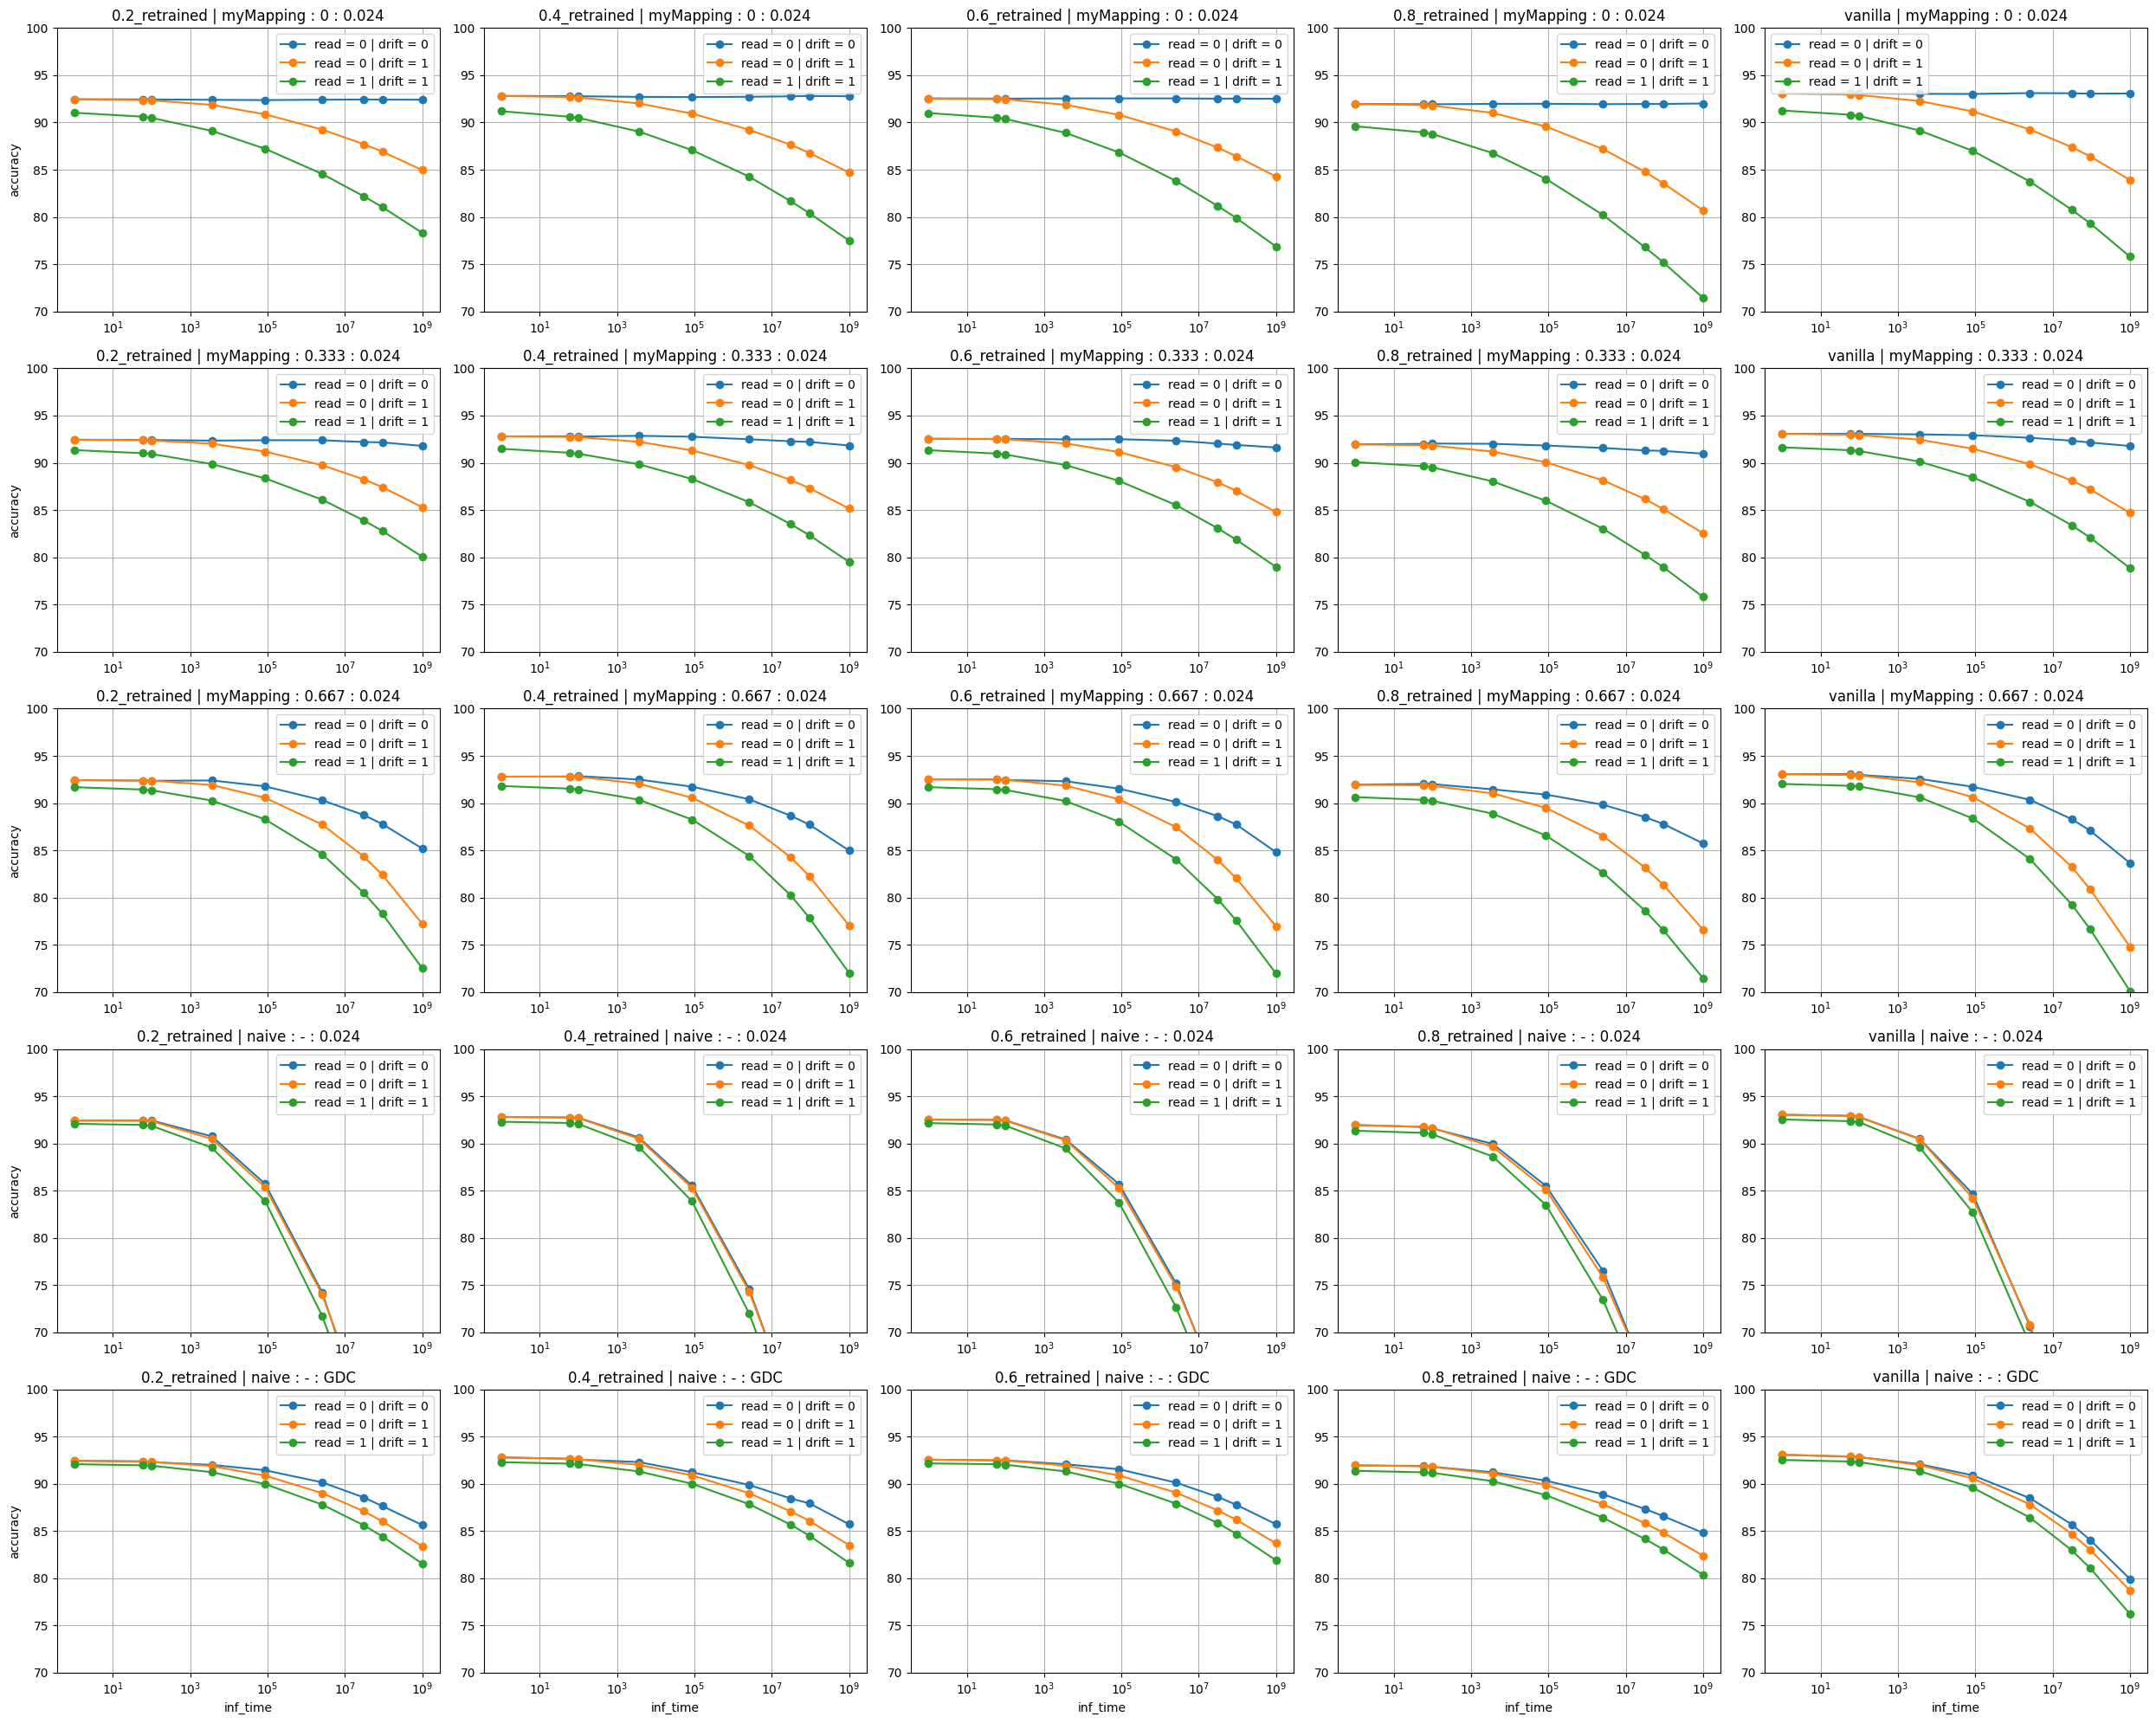

In [260]:
import matplotlib.pyplot as plt
import pandas as pd

# mapping_method 와 distortion_f 를 조합해서 새로운 column 생성
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str) + ' : ' + df['alpha'].astype(str)

# 유일한 값 추출
mapping_distortion_vals = sorted(df['mapping_distortion'].unique())
model_vals = sorted(df['model_type'].unique())
read_noise_vals = sorted(df['read_noise_scale'].unique())
drift_noise_vals = sorted(df['drift_noise_scale'].unique())

# subplot (row: mapping_distortion, col: model_type)
fig, axes = plt.subplots(len(mapping_distortion_vals), len(model_vals),
                         figsize=(5 * len(model_vals), 4 * len(mapping_distortion_vals)),
                         squeeze=False)

# plot
for i, mapping_distortion in enumerate(mapping_distortion_vals):
    for j, model in enumerate(model_vals):
        ax = axes[i][j]
        subset = df[(df['mapping_distortion'] == mapping_distortion) & (df['model_type'] == model)]

        for read_noise in read_noise_vals:
            for drift_noise in drift_noise_vals:
                rn_data = subset[(subset['read_noise_scale'] == read_noise) & 
                                (subset['drift_noise_scale'] == drift_noise)].sort_values('inf_time')

                if rn_data.empty:
                    continue

                # linestyle = '--' if read_noise == 0 else '-'
                # color = 'black' if read_noise == 0 else None
                label = f'read = {read_noise} | drift = {drift_noise}'

                ax.plot(rn_data['inf_time'], rn_data['accuracy'],
                        label=label,  marker='o')

        ax.set_title(f'{model} | {mapping_distortion}')
        if i == len(mapping_distortion_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        # GDC on일 때만 ylim (70, 100)
        if subset['GDC'].eq('on').any():
            ax.set_ylim(70, 100)
        else:
            ax.set_ylim(0, 100)

        ax.grid(True)
        ax.legend()
        if subset['inf_time'].gt(0).any():
            ax.set_xscale('log')

plt.tight_layout()
plt.show()

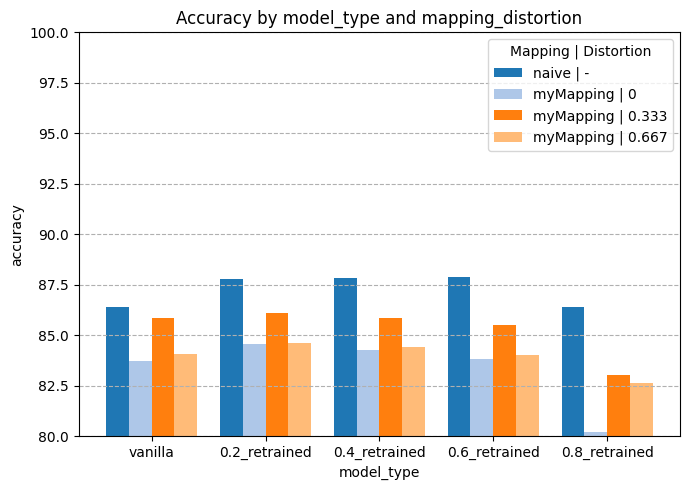

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

# mapping_method + distortion_f 조합
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' | ' + df['distortion_f'].astype(str)
df = df[df['inf_time']==2592000]
df = df[df['GDC']=='on']

# 색상 지정
colors = {md: c for md, c in zip(df['mapping_distortion'].unique(), plt.cm.tab20.colors)}

# x축 위치는 model_type 별로 구분
model_types = df['model_type'].unique()
mapping_distortions = df['mapping_distortion'].unique()
x = np.arange(len(model_types))
width = 0.8 / len(mapping_distortions)  # bar 폭 분할

fig, ax = plt.subplots(figsize=(7,5))

# 각 mapping_distortion 별로 bar plot
for idx, mapping_distortion in enumerate(mapping_distortions):
    md_data = df[df['mapping_distortion'] == mapping_distortion]
    means = []
    for model in model_types:
        subset = md_data[md_data['model_type'] == model]
        means.append(subset['accuracy'].mean() if not subset.empty else np.nan)
    bar_positions = x - 0.4 + idx * width + width / 2
    ax.bar(bar_positions, means, width=width, color=colors[mapping_distortion], label=mapping_distortion)

# x축 및 기타 설정
ax.set_xticks(x)
ax.set_xticklabels(model_types)
ax.set_xlabel('model_type')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy by model_type and mapping_distortion')
ax.legend(title='Mapping | Distortion') #, bbox_to_anchor=(1, 1), loc='upper left'
ax.set_ylim(80, 100)
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1553607/4051318159.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20b', len(mapping_distortions))


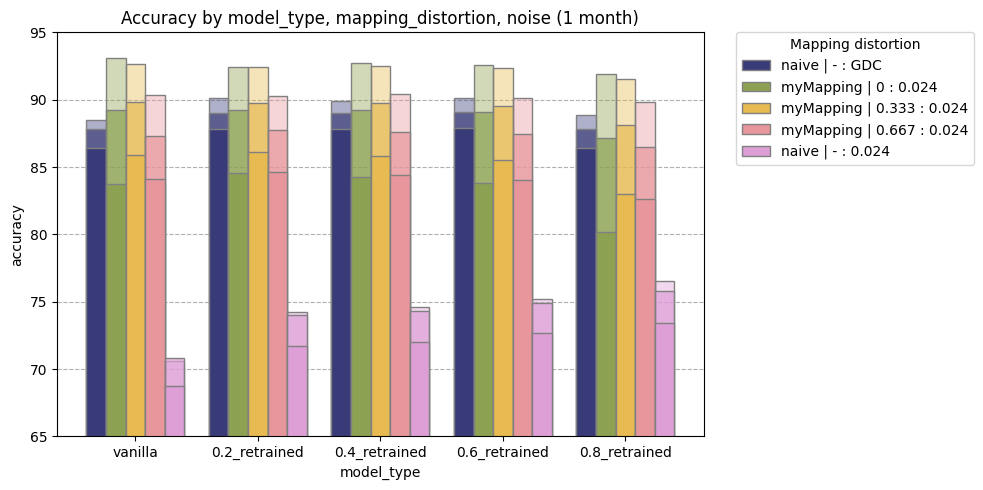

In [267]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm, colors as mcolors

# mapping_method + distortion_f 조합
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' | ' + df['distortion_f'].astype(str)  + ' : ' + df['alpha'].astype(str)
df = df[df['inf_time'] == 2592000]
df = df[df['GDC'] == 'on']

# unique 값 추출
model_types = df['model_type'].unique()
mapping_distortions = df['mapping_distortion'].unique()
noise_pairs = sorted(df[['read_noise_scale', 'drift_noise_scale']].drop_duplicates().itertuples(index=False, name=None))

# 색상 mapping (mapping_distortion 기준, 더 다양한 컬러맵)
cmap = cm.get_cmap('tab20b', len(mapping_distortions))
base_colors = {md: cmap(i) for i, md in enumerate(mapping_distortions)}

# x축 위치 정의
x = np.arange(len(model_types))
width = 0.8 / len(mapping_distortions)

fig, ax = plt.subplots(figsize=(10, 5))

# bar plot
for idx_md, mapping_distortion in enumerate(mapping_distortions):
    md_data = df[df['mapping_distortion'] == mapping_distortion]
    means_per_noise = {pair: [] for pair in noise_pairs}
    
    for read_noise, drift_noise in noise_pairs:
        noise_data = md_data[(md_data['read_noise_scale'] == read_noise) &
                             (md_data['drift_noise_scale'] == drift_noise)]
        for model in model_types:
            subset = noise_data[noise_data['model_type'] == model]
            acc = subset['accuracy'].mean() if not subset.empty else np.nan
            means_per_noise[(read_noise, drift_noise)].append(acc)
    
    bar_positions = x - 0.4 + idx_md * width + width / 2

    for idx_noise, (read_noise, drift_noise) in enumerate(noise_pairs):
        # alpha로 noise 조합 구분 (ex. 첫 noise는 진하게, 마지막은 연하게)
        alpha = 0.4 + 0.6 * (idx_noise / (len(noise_pairs)-1))
        rgba = list(mcolors.to_rgba(base_colors[mapping_distortion]))
        rgba[-1] = alpha
        label = f'Read={read_noise} | Drift={drift_noise}' if idx_md == 0 else None

        bars = ax.bar(bar_positions, means_per_noise[(read_noise, drift_noise)],
                      width=width, color=rgba, edgecolor='grey', label=mapping_distortion)

# x축 및 기타 설정
ax.set_xticks(x)
ax.set_xticklabels(model_types)
ax.set_xlabel('model_type')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy by model_type, mapping_distortion, noise (1 month)')
ax.set_ylim(65, 95)
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)

# 중복 없는 legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), title='Mapping distortion')
ax.legend(
    by_label.values(), by_label.keys(),
    title='Mapping distortion',
    bbox_to_anchor=(1.05, 1),  # x축 기준으로 오른쪽에 위치
    loc='upper left',
    borderaxespad=0.  # padding 조절
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1553607/3266509988.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


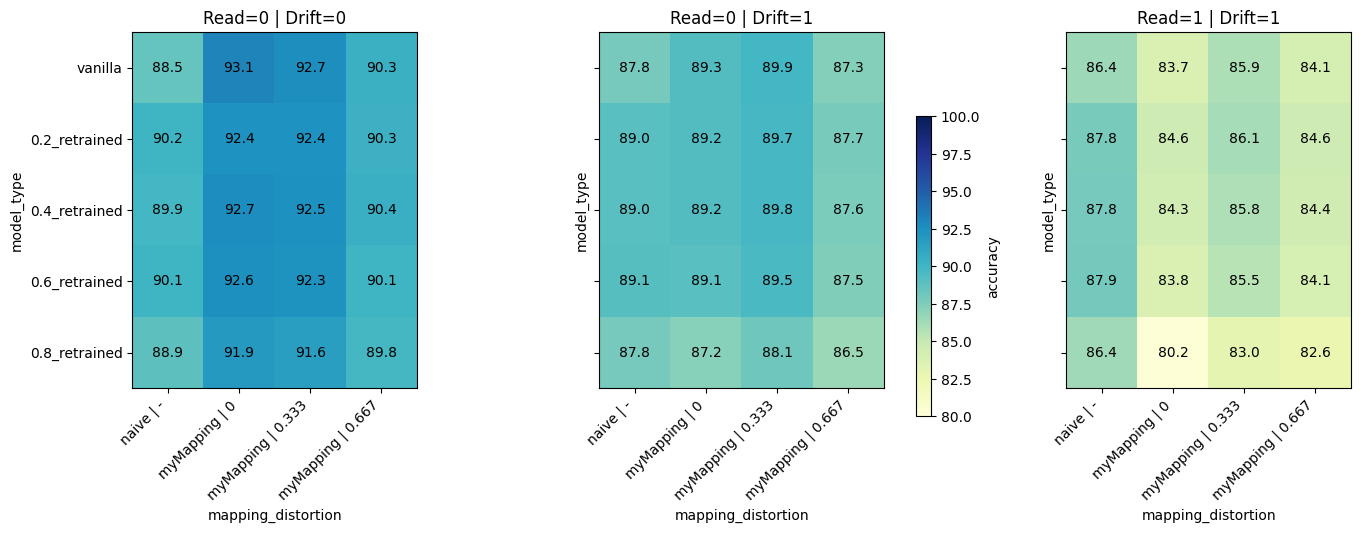

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2592000 sec, GDC on 필터링
df_filtered = df[(df['inf_time'] == 2592000) & (df['GDC'] == 'on')]

model_types = list(df_filtered['model_type'].unique())
mapping_distortions = list(df_filtered['mapping_distortion'].unique())
noise_pairs = sorted(df_filtered[['read_noise_scale', 'drift_noise_scale']].drop_duplicates().itertuples(index=False, name=None))

fig, axes = plt.subplots(1, len(noise_pairs), figsize=(5 * len(noise_pairs), 5), 
                         sharey=True,  # y축 공유
                         squeeze=False)

for idx, (read_noise, drift_noise) in enumerate(noise_pairs):
    ax = axes[0][idx]
    subset = df_filtered[
        (df_filtered['read_noise_scale'] == read_noise) &
        (df_filtered['drift_noise_scale'] == drift_noise)
    ]
    pivot = subset.pivot_table(index='model_type', columns='mapping_distortion', values='accuracy')

    # model_type / mapping_distortion 순서 맞추기 (없으면 NaN 채움)
    pivot = pivot.reindex(index=model_types, columns=mapping_distortions)

    im = ax.imshow(pivot.values, cmap='YlGnBu', vmin=80, vmax=100)
    

    # x축, y축 설정
    ax.set_xticks(np.arange(len(mapping_distortions)))
    ax.set_xticklabels(mapping_distortions, rotation=45, ha='right')

    ax.set_yticks(np.arange(len(model_types)))
    ax.set_yticklabels(model_types)

    ax.set_title(f'Read={read_noise} | Drift={drift_noise}')
    ax.set_xlabel('mapping_distortion')
    ax.set_ylabel('model_type')

    # value 표시
    for i in range(len(model_types)):
        for j in range(len(mapping_distortions)):
            value = pivot.values[i, j]
            if not np.isnan(value):
                ax.text(j, i, f'{value:.1f}', ha='center', va='center', color='black')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label='accuracy')
cbar.ax.set_position([0.7, 0.2, 0.02, 0.6])  
plt.tight_layout()
plt.show()

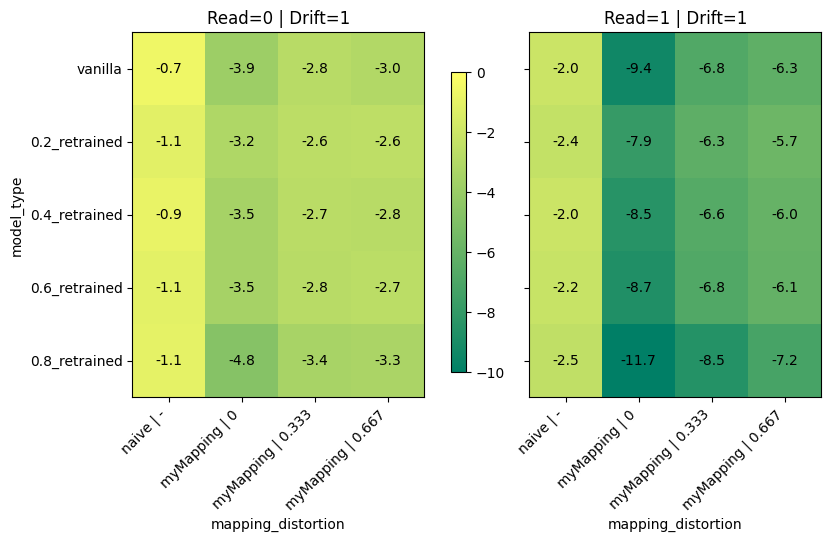

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2592000 sec, GDC on 필터링
df_filtered = df[(df['inf_time'] == 2592000) & (df['GDC'] == 'on')]

model_types = list(df_filtered['model_type'].unique())
mapping_distortions = list(df_filtered['mapping_distortion'].unique())
noise_pairs = sorted(df_filtered[['read_noise_scale', 'drift_noise_scale']].drop_duplicates().itertuples(index=False, name=None))

# baseline pivot (read=0, drift=0)
baseline = df_filtered[
    (df_filtered['read_noise_scale'] == 0) &
    (df_filtered['drift_noise_scale'] == 0)
].pivot_table(index='model_type', columns='mapping_distortion', values='accuracy')

baseline = baseline.reindex(index=model_types, columns=mapping_distortions)

# 기준에서 제외 (0, 0)
noise_pairs = [pair for pair in noise_pairs if pair != (0, 0)]

# subplot
fig, axes = plt.subplots(1, len(noise_pairs), figsize=(5 * len(noise_pairs), 5), sharey=True, squeeze=False)

for idx, (read_noise, drift_noise) in enumerate(noise_pairs):
    ax = axes[0][idx]
    subset = df_filtered[
        (df_filtered['read_noise_scale'] == read_noise) &
        (df_filtered['drift_noise_scale'] == drift_noise)
    ]
    pivot = subset.pivot_table(index='model_type', columns='mapping_distortion', values='accuracy')
    pivot = pivot.reindex(index=model_types, columns=mapping_distortions)

    # 차이 계산
    diff = pivot - baseline

    im = ax.imshow(diff.values, cmap='summer', vmin=-10, vmax=0)

    ax.set_xticks(np.arange(len(mapping_distortions)))
    ax.set_xticklabels(mapping_distortions, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(model_types)))
    ax.set_yticklabels(model_types)

    ax.set_title(f'Read={read_noise} | Drift={drift_noise}')
    ax.set_xlabel('mapping_distortion')
    if idx == 0:
        ax.set_ylabel('model_type')

    for i in range(len(model_types)):
        for j in range(len(mapping_distortions)):
            value = diff.values[i, j]
            if not np.isnan(value):
                ax.text(j, i, f'{value:.1f}', ha='center', va='center', color='black')

# colorbar 
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.set_position([0.53, 0.2, 0.02, 0.6])  

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()